In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import plots   # [NOT A THIRD PARTY LIBRARY] contains plotting functions for hyperparameter tuning and better visualation of the results (can be found at plots.py)

## Generating a frozen lake scenario

I have assumed that we always start at (0,0) and the destination is supposed to be at (N-1,N-1). \
Additionally, the frozen lake will always contain atleast one valid path from S to G.

In [2]:
# function to generate a random frozen lake, with an option to display it
def generate_frozen_lake(N, M, display = False):
    if M > (N * N - 2):
        raise ValueError(f"Too many holes! The lake has only {N*N - 2} available spaces for holes.")
    
    # Step 1: Create a grid of size N x N filled with 'F' (frozen cells)
    lake = [['F' for _ in range(N)] for _ in range(N)]

    # Step 2: Set 'S' at (0, 0) and 'G' at (N-1, N-1)
    lake[0][0] = 'S'
    lake[N-1][N-1] = 'G'

    # Step 3: Create a guaranteed path from 'S' to 'G'
    path = [(0, 0)]
    x, y = 0, 0

    # Generate a path by always moving either right or down until (N-1, N-1)
    while x < N - 1 or y < N - 1:
        if x < N - 1 and y < N - 1:
            # Randomly decide to move right or down
            if random.choice([True, False]):
                x += 1  # Move down
            else:
                y += 1  # Move right
        elif x < N - 1:
            x += 1  # Move down
        else:
            y += 1  # Move right
        path.append((x, y))

    # Step 4: Mark the cells of the valid path as part of the lake grid
    for (px, py) in path:
        lake[px][py] = 'P'  # Use 'P' to temporarily mark the path (will be replaced by 'F')

    # Step 5: Randomly place M holes 'H' in non-path positions
    all_positions = [(i, j) for i in range(N) for j in range(N)]
    available_positions = [pos for pos in all_positions if pos not in path and pos != (N-1, N-1)]
    hole_positions = random.sample(available_positions, M)

    for pos in hole_positions:
        lake[pos[0]][pos[1]] = 'H'

    # Step 6: Replace 'P' (temporary path marker) with 'F'
    for i in range(N):
        for j in range(N):
            if lake[i][j] == 'P':
                lake[i][j] = 'F'

    lake[0][0] = 'S'
    lake[N-1][N-1] = 'G'

    if display:
        plots.display_lake(lake)

    return lake

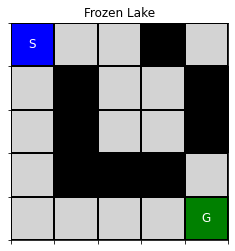

In [3]:
# Example usage:
N = 5  # Size of the lake (5x5 grid)
M = 8  # Number of holes
lake = generate_frozen_lake(N, M, True)

## Implementing a Q-learning agent 
**Q-table**: We will use a table that stores the expected reward for each state-action pair. 

**State Transitions**: The agent can move up, down, left, or right in the grid. 

**Reward**: *+1* for reaching the goal, *-1* for falling into a hole and *0* for any other move. 

**Termination Criteria**:
The agent will stop if it reaches G or reaches a maximum of 25 steps.

### Strategy : ε-greedy

The ε-greedy strategy allows the agent to learn about the environment while still leveraging known information to maximize rewards. 
* For each action selection step, the agent generates a random number between 0 and 1.
* If this number is less than ε, the agent chooses a random action (exploration).
* If the number is greater than or equal to ε, the agent selects the action with the highest Q-value (exploitation).

ε is set to **decrease over time (decay)** so that the agent explores more in the beginning and gradually focuses on exploiting the best-known actions as it learns.

In [4]:
# Helper functions and definitions for the Frozen Lake environment

# Actions and movement in the grid
actions = ['up', 'down', 'left', 'right']
action_mapping = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0)}

# Check if the new position is within bounds
def is_valid(pos, N):
    return 0 <= pos[0] < N and 0 <= pos[1] < N

# Reward function for the environment
def get_reward(lake, pos, N):
    if pos == (N-1, N-1):  # Goal
        # print('Goal reached!')
        return 1, True
    elif lake[pos[0]][pos[1]] == 'H':  # Hole
        return -1, False
    else:  # Safe move
        return 0, False

In [5]:
# Initialize the Q-learning agent
def q_learning_frozen_lake(lake, N, episodes=1000, max_steps=100, alpha=0.1, gamma=0.9, epsilon=1.0):
    q_table = np.zeros((N * N, len(actions)))  # Initialize Q-table

    rewards_per_episode = []
    steps_per_episode = []
    epsilon_decay = 0.995  # Reduce epsilon over time
    epsilon_min = 0.01

    for episode in range(episodes):
        state = (0, 0)  # Start position (S)
        total_reward = 0
        total_steps = 0

        for step in range(max_steps):
            # Convert state (row, col) into an index for the Q-table
            state_index = state[0] * N + state[1]

            # Epsilon-greedy policy: Explore or Exploit
            if random.uniform(0, 1) < epsilon:
                action_index = random.choice(range(len(actions)))  # Explore
            else:
                action_index = np.argmax(q_table[state_index])  # Exploit

            action = actions[action_index]
            next_state = (state[0] + action_mapping[action][0], state[1] + action_mapping[action][1])

            # Ensure the agent does not move out of bounds
            if not is_valid(next_state, N):
                next_state = state  # Stay in the same place if the move is invalid

            # Get reward and check if the episode ends
            reward, done = get_reward(lake, next_state, N)
            total_reward += reward

            # Update Q-value using the Q-learning update rule
            next_state_index = next_state[0] * N + next_state[1]
            q_table[state_index, action_index] = q_table[state_index, action_index] + alpha * (
                reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action_index]
            )

            state = next_state  # Move to the next state

            if done:
                total_steps = step + 1  # Total steps in the episode
                break  # End episode if the agent reaches goal or falls into a hole

        # Steps timed-out (did not reach the goal)
        total_steps = max_steps if total_steps == 0 else total_steps

        # Decay epsilon (reduce exploration over time)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Store total reward per episode and total steps per episode
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(total_steps)

    return q_table, rewards_per_episode, steps_per_episode

     

#### Now we will test our Q-learning algorithm for a 5x5 grid with 6 holes

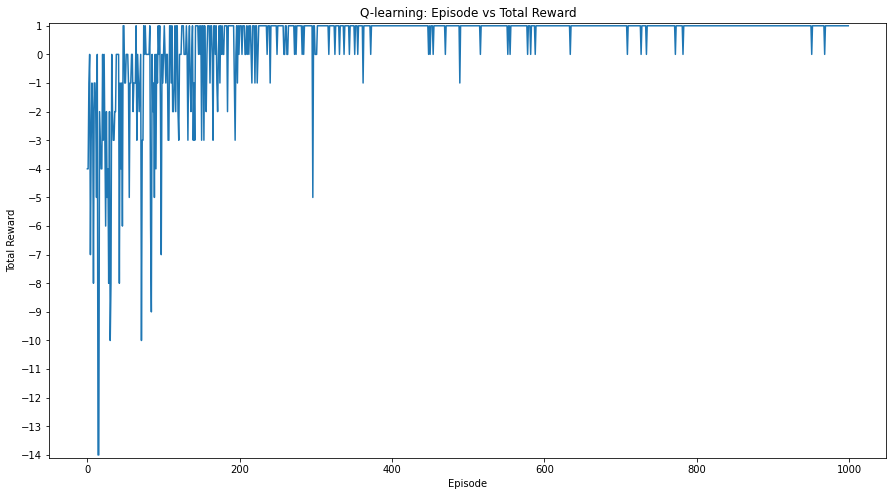

In [6]:
# Initialize parameters
N = 5           # Grid size
M = 6           # Number of holes
episodes = 1000 # Number of episodes
max_steps = 25  # Maximum steps per episode

# Generate the frozen lake environment
lake = generate_frozen_lake(N, M)

# Train the Q-learning agent
q_table, rewards_per_episode, _ = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps)

# Plot the rewards per episode
plots.plot_results(rewards_per_episode)

We can see that intially for the first 150-200 episodes, the Q-agent is facing highly negative rewards as it is exploring the environment and falling into holes. However, the agent starts reaching G more often as the episodes increase, and post 400-500 episodes, it pretty reliably learns to reach G from S.

## Testing performance with changes in α and λ

#### We will measure performance using the following two metrics:

1. **Average Reward** : A rolling measure of the average reward over the last 50 episodes.
2. **Average Steps** : A rolling measure of the average number of steps taken over the last 50 episodes.

Here a demonstration of these metrics on an arbitrary frozen lake scenario

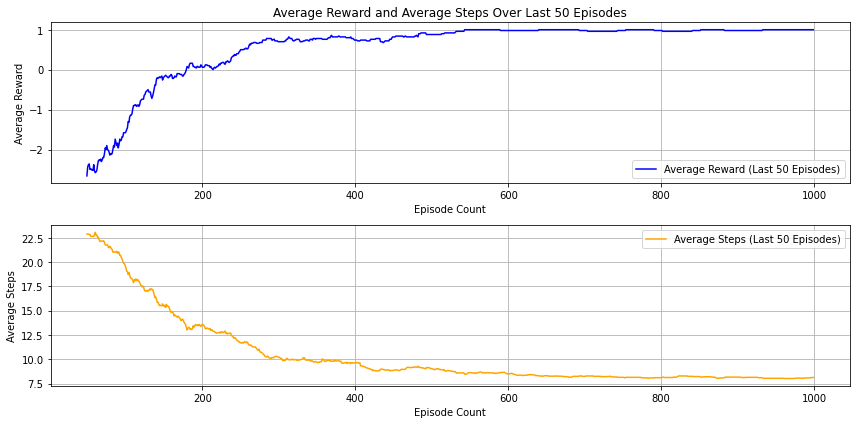

In [7]:
# Initialize parameters
N = 5           # Grid size
M = 6           # Number of holes
episodes = 1000 # Number of episodes
max_steps = 25  # Maximum steps per episode

# Generate the frozen lake environment
lake = generate_frozen_lake(N, M)

# Train the Q-learning agent
q_table, rewards_per_episode, steps_per_episode = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps)

# Plot the rewards per episode
plots.plot_average_metrics(rewards_per_episode, steps_per_episode)

As expected, the **average reward increases to 1** and the **average steps taken to reach G reduce** over time as the Q-agent learns the environment. Now let us vary some parameters.

### Varying the learning rate (α) [with λ = 0.9 fixed]

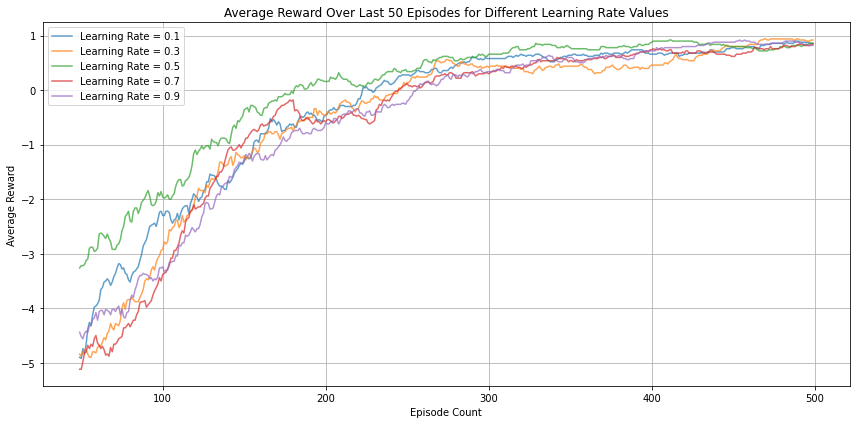

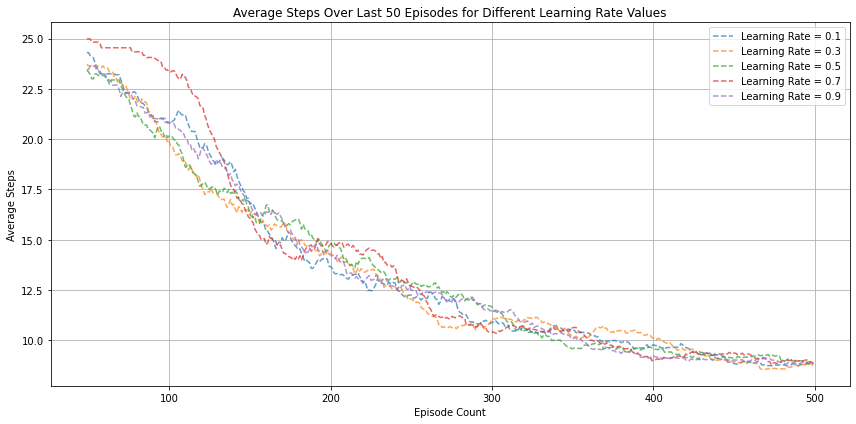

In [12]:
# Initialize the parameters
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
# alphas = [0.05, 0.5]
episodes = 500
max_steps = 25
N = 5
M = 6

rewards_data = []
steps_data = []

# Create a new frozen lake environment
lake = generate_frozen_lake(N, M)

# Run Q-learning on multiple alpha values
for alpha in alphas:
        
    # Run Q-learning on this environment
    _, rewards_per_episode, steps_per_episode = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps, alpha=alpha)
            
    # Append rewards and steps to corresponding lists for this alpha
    rewards_data.append(rewards_per_episode)
    steps_data.append(steps_per_episode)
    
# plot the metrics for varying alpha values
plots.plot_metrics_for_varying_param(rewards_data, steps_data, alphas, 'Learning Rate')

Over time it seems that the differnces in Q-learning based on different learning rates **seems to disappear**. There doesn't seem to be a clear trend in how the learning rate affects the average reward and number of steps taken.

### Varying the discount factor (λ) [with α = 0.1 fixed]

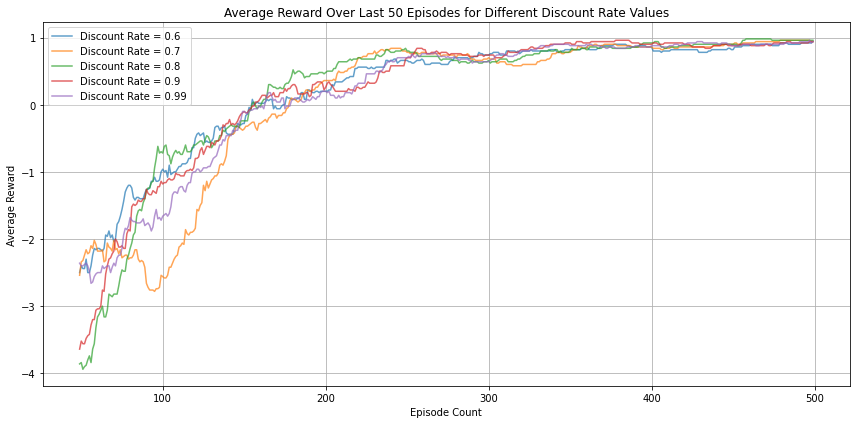

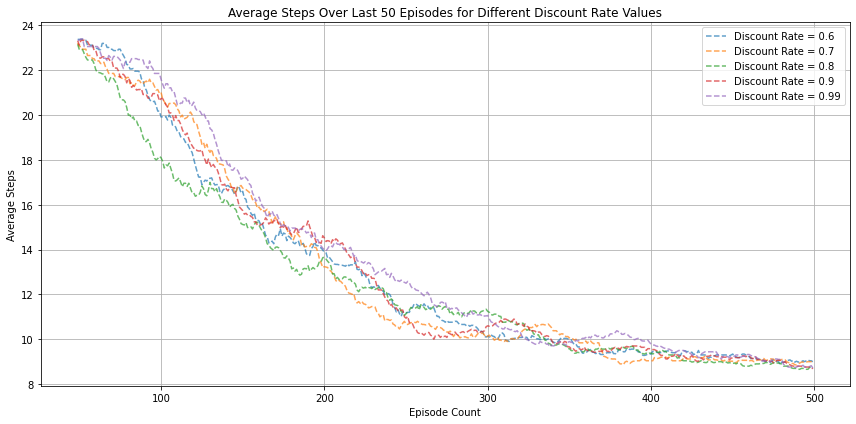

In [13]:
# Initialize the parameters
gammas = [0.6, 0.7, 0.8, 0.9, 0.99]
episodes = 500
max_steps = 25
N = 5
M = 6

rewards_data = []
steps_data = []

# Create a new frozen lake environment
lake = generate_frozen_lake(N, M)

# Run Q-learning on multiple alpha values
for gamma in gammas:
        
    # Run Q-learning on this environment
    _, rewards_per_episode, steps_per_episode = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps, gamma=gamma)
            
    # Append rewards and steps to corresponding lists for this gamma
    rewards_data.append(rewards_per_episode)
    steps_data.append(steps_per_episode)
    
# plot the metrics for varying gamma values
plots.plot_metrics_for_varying_param(rewards_data, steps_data, gammas, 'Discount Rate')

Over time it seems that the differnces in Q-learning based on different discount rates **seems to disappear**. Again, it seems that variation in discount factor is not leading to a big difference in the average rewards and steps taken.

## Testing performance with changes in N and M

### Varying M (with N fixed at 5)

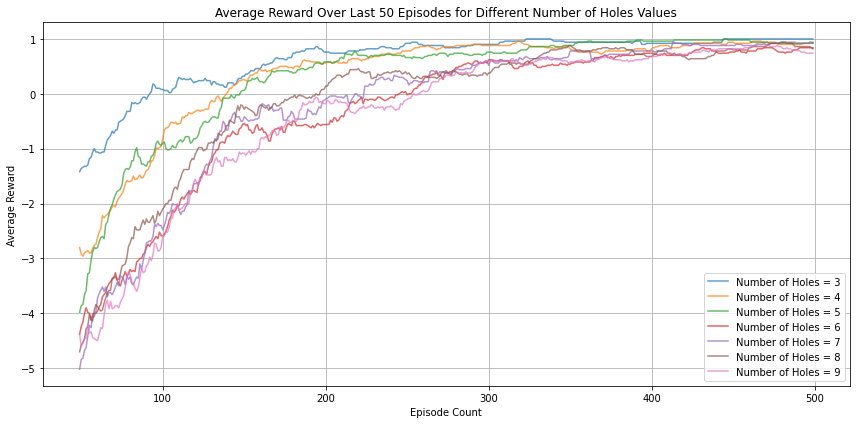

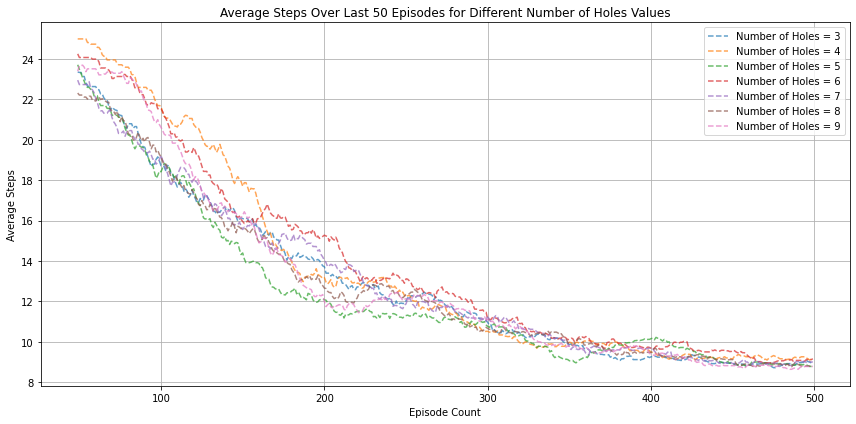

In [14]:
# Initialize the parameters
episodes = 500
max_steps = 25
N = 5
list_M = [ 3, 4, 5, 6, 7, 8, 9 ]


rewards_data = []
steps_data = []

# Run Q-learning on multiple frozen lakes
for M in list_M:
    # Create a new frozen lake environment
    lake = generate_frozen_lake(N, M)
        
    # Run Q-learning on this environment
    _, rewards_per_episode, steps_per_episode = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps)
            
    # Append rewards and steps to corresponding lists for this gamma
    rewards_data.append(rewards_per_episode)
    steps_data.append(steps_per_episode)
    
# plot the metrics for varying M values
plots.plot_metrics_for_varying_param(rewards_data, steps_data, list_M, 'Number of Holes')

**We can see that convergence to a higher average reward is quicker when the number of holes (M) is smaller.** 

**The same trend can be seen for average number of steps taken, as M increases, it takes longer to decrease the number of steps.**

### Varying N (with M fixed at 5)

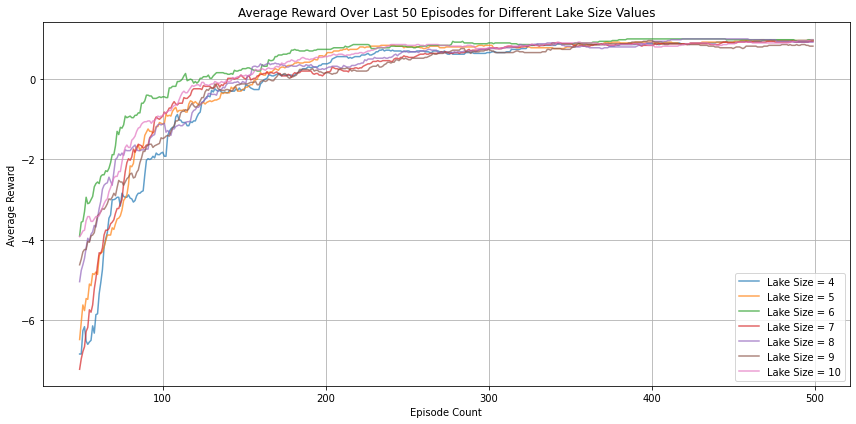

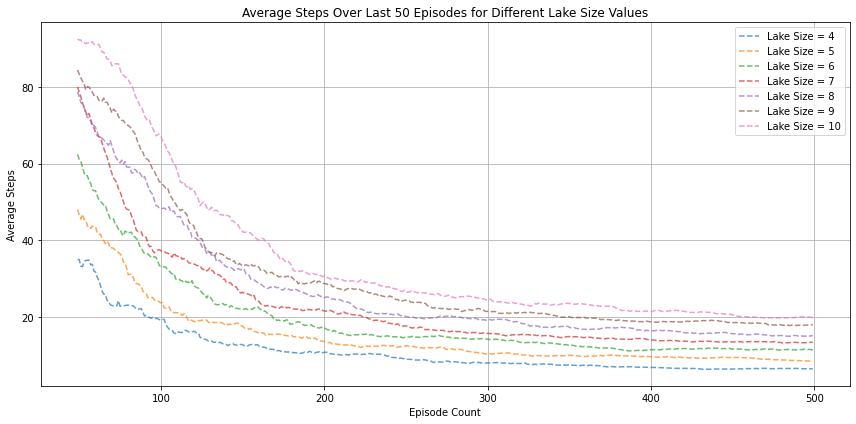

In [18]:
# Initialize the parameters
episodes = 500
max_steps = 100
M = 5
list_N = [4, 5, 6, 7, 8, 9, 10 ]


rewards_data = []
steps_data = []

# Run Q-learning on multiple frozen lakes
for N in list_N:
    # Create a new frozen lake environment
    lake = generate_frozen_lake(N, M)
        
    # Run Q-learning on this environment
    _, rewards_per_episode, steps_per_episode = q_learning_frozen_lake(lake, N, episodes=episodes, max_steps=max_steps)
            
    # Append rewards and steps to corresponding lists for this gamma
    rewards_data.append(rewards_per_episode)
    steps_data.append(steps_per_episode)
    
# plot the metrics for varying M values
plots.plot_metrics_for_varying_param(rewards_data, steps_data, list_N, 'Lake Size')

**We can see that as we increase the lake size (N), the performance of the Q-learning agent worsens slightly, with it taking longer to achieve higher reward, and reduce number of steps to reach the destination.**